In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import pandas as pd
import git
import os
from scipy import signal
from scipy.stats import pearsonr
from scipy.ndimage import shift
from statannotations.Annotator import Annotator
import seaborn as sns

# Get git repository root
repo = git.Repo(".", search_parent_directories = True)
# Update notebook working dir to repository root
os.chdir(repo.working_tree_dir)

# Load frequently used methods
with open("notebooks/methods.py", "r") as file:
    exec(file.read())

with open("python/merge_close_events.py", "r") as file:
    exec(file.read())

# Detection of movement episodes

In [2]:
samples = pd.read_csv("sample_sheet.csv")
sample = samples.iloc[0]
sample

SID              W1_C1
AnimalID            W1
CellName            C1
Region          S1_L23
Date        2019 12 09
Depth       177.265396
Count              180
Location         W1/C1
Cortex              S1
Layer              L23
Name: 0, dtype: object

In [3]:
data = pd.read_pickle(f"output/movement-s1-m1/{sample['AnimalID']}/{sample['CellName']}/emg/filter.pkl")
channels = data.ch_names

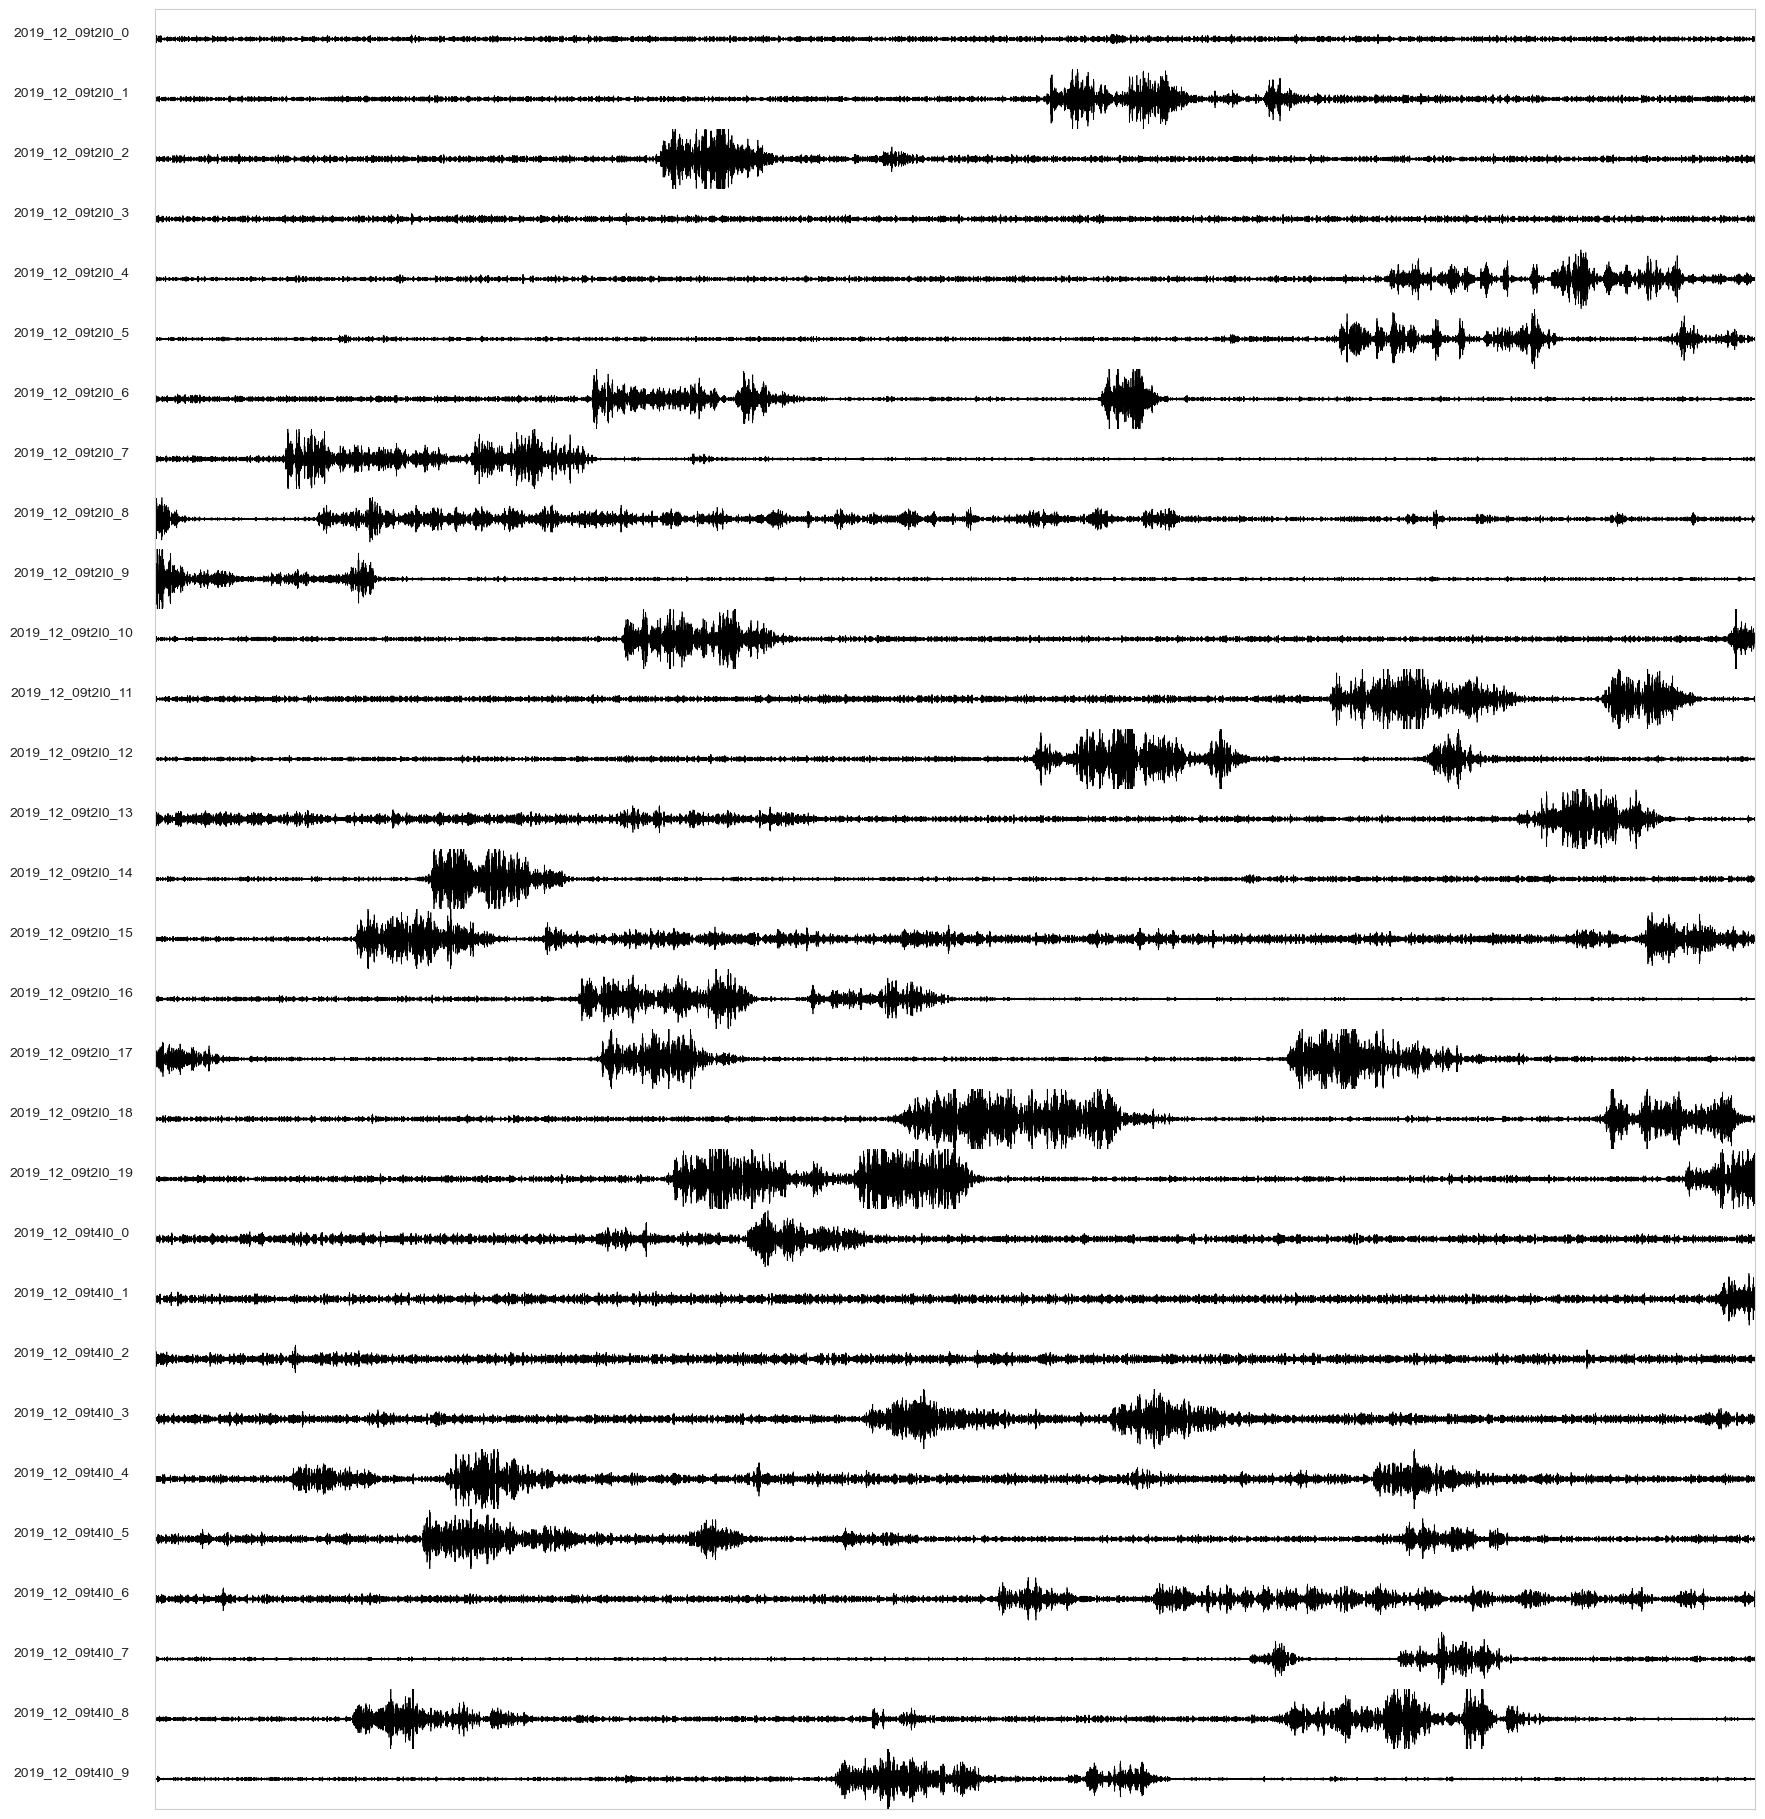

In [4]:
plot_channels(data = data.get_data().T, time = data.times, channels = channels, limit = 10)

## Movement detection using upper 10th percentile cutoff

In [5]:
sample_data = data.get_data()
threshold = np.percentile(np.abs(sample_data), 90)
channel_data = sample_data[1]

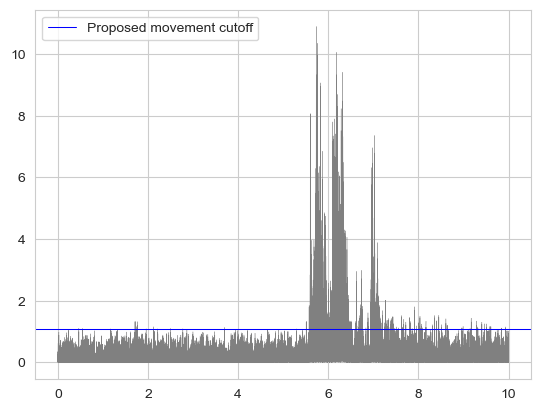

In [6]:
plt.plot(data.times, np.abs(channel_data), c = "gray", linewidth = 0.25)
plt.axhline(y = threshold, color = "blue", linestyle = "-", linewidth = 0.75, label = "Proposed movement cutoff")
plt.legend()
plt.show()

In [7]:
signal_over_threshold = np.abs(channel_data) > threshold
change_indices = np.where(np.diff(signal_over_threshold))[0]

movement_data = pd.DataFrame({
    "EventStart": np.insert(change_indices + 1, 0, 0),
    "EventEnd": np.append(change_indices + 1, len(signal_over_threshold))
})

movement_data["Movement"] = signal_over_threshold[movement_data["EventStart"]]
movement_data = movement_data[movement_data["Movement"]]
movement_data["EventLength"] = list(movement_data["EventEnd"] - movement_data["EventStart"])

movement_data = merge_close_events(movement_data, min_break = 500)

movement_data["Start"] = movement_data["EventStart"] / data.info["sfreq"]
movement_data["End"] = movement_data["EventEnd"] / data.info["sfreq"]
movement_data["Length"] = movement_data["EventLength"] / data.info["sfreq"]

movement_data = movement_data[movement_data["EventLength"] >= 5000]

In [8]:
movement_data

,EventStart,EventEnd,Movement,EventLength,Start,End,Length
13,111445,130140,True,18695,5.57225,6.5070,0.93475
18,138682,144196,True,5514,6.93410,7.2098,0.27570


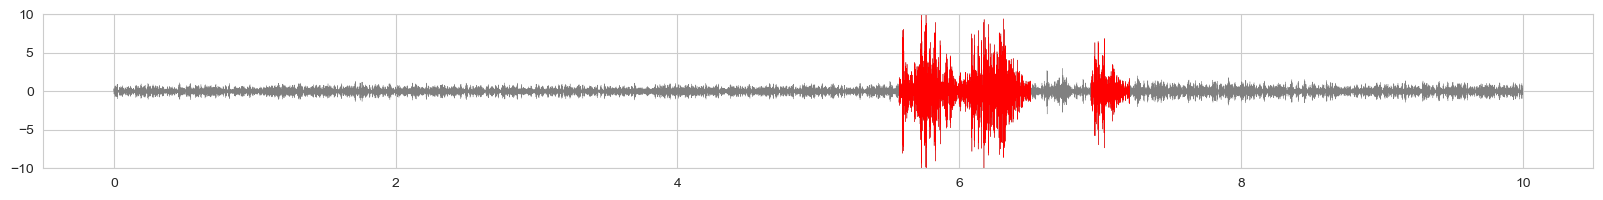

In [9]:
plt.figure(figsize = (20, 2))

x = data.times
y = channel_data

plt.plot(x, y, c = "gray", linewidth = 0.25)

for i, episode in movement_data.iterrows():
    x = data.times[episode["EventStart"]:episode["EventEnd"]]
    y = channel_data[episode["EventStart"]:episode["EventEnd"]]

    plt.plot(x, y, c = "red", linewidth = 0.25)

plt.ylim(-10, 10)
plt.show()